In [17]:
with rasterio.open(dem_path) as src:
    dem = src.read(1).astype(float)

# Mask nodata manually
dem[(dem == 0) | (dem == 65535)] = np.nan

print("Valid pixels left:", np.count_nonzero(~np.isnan(dem)))

if np.count_nonzero(~np.isnan(dem)) == 0:
    print("⚠️ No valid DEM data in this AOI – try downloading a different DEM product (e.g., GLO-30).")
else:
    print("DEM OK – Stats:")
    print("  Min:", np.nanmin(dem))
    print("  Max:", np.nanmax(dem))
    print("  Mean:", np.nanmean(dem))
    print("  Std:", np.nanstd(dem))


Valid pixels left: 0
⚠️ No valid DEM data in this AOI – try downloading a different DEM product (e.g., GLO-30).


Raw ranges -> red: 0.0 34891.0  green: 0.0 31404.0  blue: 0.0 28075.0
Auto-scaled bands by 10000 (converted to ~0..1 reflectance).


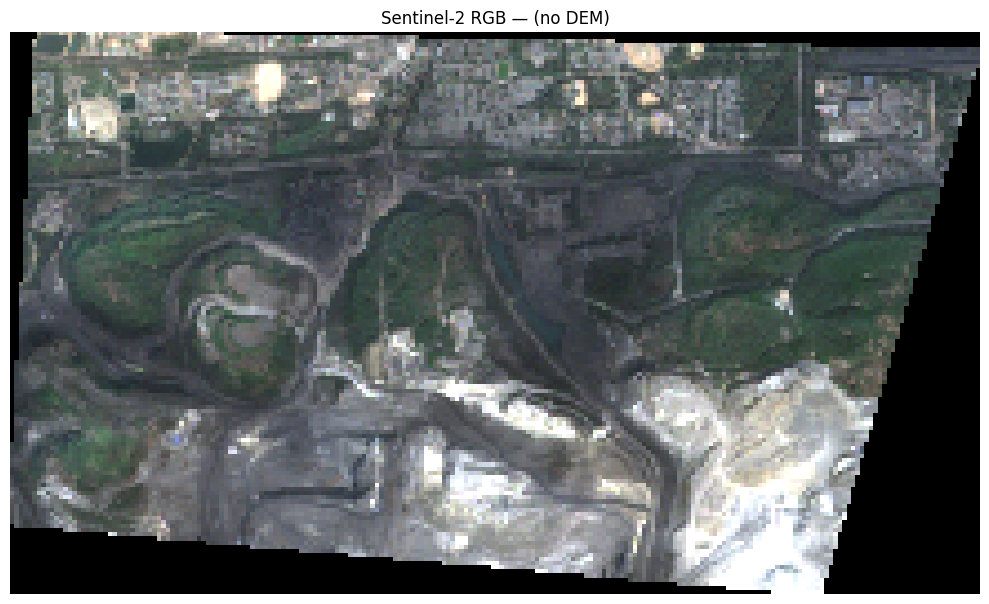

In [39]:
import numpy as np
import rasterio
import matplotlib.pyplot as plt

# ---- Uses your existing paths: b4_path (Red), b3_path (Green), b2_path (Blue) ----

# Load bands (as float)
with rasterio.open(b4_path) as src:
    red = src.read(1).astype('float32')
    extent = rasterio.plot.plotting_extent(src)   # geo extent for plotting
with rasterio.open(b3_path) as src:
    green = src.read(1).astype('float32')
with rasterio.open(b2_path) as src:
    blue = src.read(1).astype('float32')

# Quick diagnostics (helps identify scaling issues)
print("Raw ranges -> red:", red.min(), red.max(),
      " green:", green.min(), green.max(),
      " blue:", blue.min(), blue.max())

# Auto-scale common Sentinel-2 L2A reflectance (if values look like 0..10000)
if max(red.max(), green.max(), blue.max()) > 1.1:
    red /= 10000.0
    green /= 10000.0
    blue /= 10000.0
    print("Auto-scaled bands by 10000 (converted to ~0..1 reflectance).")

# Per-band contrast stretch (2nd-98th percentile)
def normalize(band, p_low=2, p_high=98):
    p_lo, p_hi = np.percentile(band, (p_low, p_high))
    return np.clip((band - p_lo) / (p_hi - p_lo), 0.0, 1.0)

r_n = normalize(red)
g_n = normalize(green)
b_n = normalize(blue)

# Stack to RGB
rgb = np.dstack((r_n, g_n, b_n))

# Optional: gamma correction to tweak brightness (try 1.0, 1.2, 0.8)
gamma = 1.2
rgb = np.clip(rgb ** (1.0 / gamma), 0, 1)

# Display
fig, ax = plt.subplots(figsize=(10, 10))
ax.imshow(rgb, extent=extent)
ax.set_title("Sentinel-2 RGB — (no DEM)")
ax.set_axis_off()     # hide axes for cleaner visual; remove if you want coords visible
plt.tight_layout()
plt.show()


In [5]:
import os
import numpy as np
import rasterio
import matplotlib.pyplot as plt
from matplotlib.colors import LightSource # <<< The key alternative import

# -----------------------------
# --- 1. DEFINE FILE PATHS ---
# -----------------------------
# Path to the smoothed DEM you created previously
dem_path = "/Users/chaitanyakartik/Projects/AgroSpectra/data/SRTM-DEM/Synthetic_Data/pseudo_dem_smoothed.tiff"

# Paths to the Sentinel-2 bands for the true-color RGB image
rgb_data_dir = "/Users/chaitanyakartik/Projects/AgroSpectra/data/Sentinel2-Hyperspectral/EO_Browser_images/Korba_Coal_AOI1_RGB"

b2_path = os.path.join(rgb_data_dir, "2023-01-10-00:00_2023-01-10-23:59_Sentinel-2_L2A_B02_(Raw).tiff") # Blue
b3_path = os.path.join(rgb_data_dir, "2023-01-10-00:00_2023-01-10-23:59_Sentinel-2_L2A_B03_(Raw).tiff") # Green
b4_path = os.path.join(rgb_data_dir, "2023-01-10-00:00_2023-01-10-23:59_Sentinel-2_L2A_B04_(Raw).tiff") # Red

# -----------------------------
# --- 2. LOAD AND PREPARE DATA ---
# -----------------------------
# Load the DEM
with rasterio.open(dem_path) as src:
    dem = src.read(1)
    extent = rasterio.plot.plotting_extent(src)

# Load the RGB bands
with rasterio.open(b4_path) as src:
    red = src.read(1)
with rasterio.open(b3_path) as src:
    green = src.read(1)
with rasterio.open(b2_path) as src:
    blue = src.read(1)

# Function to normalize bands for better visual contrast
def normalize(band):
    p2, p98 = np.percentile(band, (2, 98))
    return np.clip((band - p2) / (p98 - p2), 0, 1)

# Stack the bands into a display-ready RGB image
rgb = np.dstack((normalize(red), normalize(green), normalize(blue)))
print("Data loaded and RGB composite created.")

# -----------------------------------------------------------
# --- 3. GENERATE HILLSHADE (MATPLOTLIB METHOD) ---
# -----------------------------------------------------------
print("Generating hillshade with Matplotlib LightSource...")

# Create a LightSource object, specifying the sun's angle
ls = LightSource(azdeg=315, altdeg=45)

# Generate the hillshade. The `shade` method returns an RGBA array.
# We use a gray colormap to create a classic hillshade effect.
hs = ls.shade(dem, cmap=plt.cm.gray, vert_exag=5, blend_mode='soft')

# -----------------------------
# --- 4. PLOT THE OVERLAY ---
# -----------------------------
print("Plotting the overlay...")
fig, ax = plt.subplots(1, 1, figsize=(12, 12))

# Plot the hillshade (which is already an RGBA image)
ax.imshow(hs, extent=extent)

# Plot the RGB image on top with transparency
ax.imshow(rgb, extent=extent, alpha=0.6)

ax.set_title("RGB Image Overlaid on Matplotlib Hillshade")
ax.set_xlabel("Longitude")
ax.set_ylabel("Latitude")
plt.show()

AttributeError: module 'rasterio' has no attribute 'plot'

In [6]:
import numpy as np
import rasterio
import matplotlib.pyplot as plt
from matplotlib.colors import LightSource

# Load DEM
with rasterio.open(dem_path) as src:
    dem = src.read(1).astype(float)
    extent = rasterio.plot.plotting_extent(src)

# Mask invalid values
dem = np.where(dem <= 0, np.nan, dem)

# Create hillshade
ls = LightSource(azdeg=315, altdeg=45)
hillshade = ls.hillshade(dem, vert_exag=1, dx=1, dy=1)

# Plot DEM with sharp pixels
fig, ax = plt.subplots(figsize=(10, 10))

cmap = plt.cm.terrain
im = ax.imshow(dem, cmap=cmap, extent=extent,
               interpolation="none")  # 🚀 key fix (no smoothing)

# Overlay hillshade
ax.imshow(hillshade, cmap="gray", extent=extent,
          alpha=0.3, interpolation="none")

# Add colorbar
cbar = plt.colorbar(im, ax=ax, shrink=0.7)
cbar.set_label("Elevation (m)")

ax.set_title("Sharp DEM with Terrain Color Ramp + Hillshade", fontsize=14)
ax.set_xlabel("Longitude")
ax.set_ylabel("Latitude")

plt.tight_layout()
plt.show()


AttributeError: module 'rasterio' has no attribute 'plot'

In [7]:
# plotly_3d_dem_plot.py
import numpy as np
import rasterio
import plotly.graph_objects as go
import plotly.io as pio
pio.renderers.default = "browser"


# paths (replace with your paths)
dem_path = "/Users/chaitanyakartik/Projects/AgroSpectra/data/SRTM-DEM/Synthetic_Data/pseudo_dem_smoothed.tiff"
b2_path = os.path.join(rgb_data_dir, "2023-01-10-00:00_2023-01-10-23:59_Sentinel-2_L2A_B02_(Raw).tiff") # Blue
b3_path = os.path.join(rgb_data_dir, "2023-01-10-00:00_2023-01-10-23:59_Sentinel-2_L2A_B03_(Raw).tiff") # Green
b4_path = os.path.join(rgb_data_dir, "2023-01-10-00:00_2023-01-10-23:59_Sentinel-2_L2A_B04_(Raw).tiff") # Red

# Read DEM
with rasterio.open(dem_path) as src:
    dem = src.read(1).astype(float)
    transform = src.transform
    h, w = dem.shape
    # coordinates arrays for x and y
    xs = np.linspace(transform[2], transform[2] + transform[0] * w, w)
    ys = np.linspace(transform[5], transform[5] + transform[4] * h, h)

# Read RGB and normalize (simple)
with rasterio.open(b4_path) as src: r = src.read(1).astype(np.float32)
with rasterio.open(b3_path) as src: g = src.read(1).astype(np.float32)
with rasterio.open(b2_path) as src: b = src.read(1).astype(np.float32)

# Many Sentinel-2 L2A bands are scaled by 10000 — automatically rescale if necessary
if max(r.max(), g.max(), b.max()) > 1.1:
    r /= 10000.0; g /= 10000.0; b /= 10000.0

# Optionally downsample for performance (uncomment to use)
# factor = 4
# dem = dem[::factor, ::factor]
# r = r[::factor, ::factor]; g = g[::factor, ::factor]; b = b[::factor, ::factor]
# xs = xs[::factor]; ys = ys[::factor]

# Make RGB image and compute luminance for coloring
rgb = np.dstack((r, g, b))
lum = 0.2126 * r + 0.7152 * g + 0.0722 * b  # luminance

# Ensure xs and ys are 2D grids for surface
X, Y = np.meshgrid(xs, ys)

# Build plotly surface
fig = go.Figure(data=[
    go.Surface(
        x=X, y=Y, z=dem,
        surfacecolor=lum,            # uses luminance for coloring
        colorscale='Turbo',          # choose colorscale or 'gray' etc.
        cmin=lum.min(), cmax=lum.max(),
        lighting=dict(ambient=0.7, diffuse=0.8, roughness=0.9),
        lightposition=dict(x=100000, y=100000, z=100000),
        showscale=True,
    )
])

fig.update_layout(
    scene=dict(
        xaxis_title='Longitude',
        yaxis_title='Latitude',
        zaxis_title='Elevation (m)',
        aspectmode='auto'
    ),
    title='Interactive DEM surface (Plotly) — RGB luminance draped'
)

fig.show()


In [8]:
import numpy as np
import rasterio
from scipy.ndimage import binary_opening, binary_closing
from skimage.morphology import remove_small_objects

# --- STEP 1: Define the absolute path to your main project folder ---
project_root = "/Users/chaitanyakartik/Projects/AgroSpectra"

# --- STEP 2: Build the rest of the paths automatically ---
data_root = os.path.join(project_root, "data", "Sentinel2-Hyperspectral", "EO_Browser_images")
# --- Define paths for the January 10th data ---
date_folder_jan10 = 'Korba_Coal_AOI1_Jan10'
data_dir_jan10 = os.path.join(data_root, date_folder_jan10)
base_filename_jan10 = '2023-01-10-00:00_2023-01-10-23:59_Sentinel-2_L2A'

b4_path_jan10 = os.path.join(data_dir_jan10, f'{base_filename_jan10}_B04_(Raw).tiff')
b3_path_jan10 = os.path.join(data_dir_jan10, f'{base_filename_jan10}_B03_(Raw).tiff')
b2_path_jan10 = os.path.join(data_dir_jan10, f'{base_filename_jan10}_B02_(Raw).tiff')
b8_path_jan10 = os.path.join(data_dir_jan10, f'{base_filename_jan10}_B08_(Raw).tiff')
b11_path_jan10 = os.path.join(data_dir_jan10, f'{base_filename_jan10}_B11_(Raw).tiff')

# --- Define paths for the January 30th data ---
date_folder_jan30 = 'Korba_Coal_AOI1_Jan30'
data_dir_jan30 = os.path.join(data_root, date_folder_jan30)
base_filename_jan30 = '2023-01-30-00:00_2023-01-30-23:59_Sentinel-2_L2A'

b4_path_jan30 = os.path.join(data_dir_jan30, f'{base_filename_jan30}_B04_(Raw).tiff')
b8_path_jan30 = os.path.join(data_dir_jan30, f'{base_filename_jan30}_B08_(Raw).tiff')
b11_path_jan30 = os.path.join(data_dir_jan30, f'{base_filename_jan30}_B11_(Raw).tiff')
# -------------------------
# Helper functions
# -------------------------
def read_band(path):
    with rasterio.open(path) as src:
        arr = src.read(1).astype(float)
        profile = src.profile
    # Sentinel L2A scaling
    if arr.max() > 1.1:
        arr /= 10000.0
    return arr, profile

def compute_ndvi(nir, red):
    return (nir - red) / (nir + red + 1e-8)

def compute_change_mask(ndvi_before, ndvi_after, swir_before, swir_after, ndvi_thresh=0.2, swir_thresh=0.05, min_area_pixels=100):
    # NDVI drop
    ndvi_diff = ndvi_before - ndvi_after
    ndvi_mask = ndvi_diff > ndvi_thresh

    # SWIR increase (bare soil)
    swir_diff = swir_after - swir_before
    swir_mask = swir_diff > swir_thresh

    # Combine masks
    mask = np.logical_or(ndvi_mask, swir_mask)

    # Morphological clean
    mask = binary_closing(mask, structure=np.ones((3,3)))
    mask = binary_opening(mask, structure=np.ones((3,3)))
    mask = remove_small_objects(mask.astype(bool), min_size=min_area_pixels)

    return mask.astype(np.uint8)

# -------------------------
# Load bands for both dates
# -------------------------
b4_jan10, profile = read_band(b4_path_jan10)
b8_jan10, _ = read_band(b8_path_jan10)
b11_jan10, _ = read_band(b11_path_jan10)

b4_jan30, _ = read_band(b4_path_jan30)
b8_jan30, _ = read_band(b8_path_jan30)
b11_jan30, _ = read_band(b11_path_jan30)

# -------------------------
# Compute NDVI and change mask
# -------------------------
ndvi_jan10 = compute_ndvi(b8_jan10, b4_jan10)
ndvi_jan30 = compute_ndvi(b8_jan30, b4_jan30)

mined_mask = compute_change_mask(ndvi_jan10, ndvi_jan30, b11_jan10, b11_jan30,
                                 ndvi_thresh=0.2, swir_thresh=0.15, min_area_pixels=100)

# -------------------------
# Save mined mask for visualization
# -------------------------
mask_path = "mined_mask_jan10_to_jan30.tif"
with rasterio.open(mask_path, 'w', **profile) as dst:
    dst.write(mined_mask, 1)

print(f"Mined mask saved to {mask_path}")
print(f"Estimated mined area (pixels): {mined_mask.sum()}")


Mined mask saved to mined_mask_jan10_to_jan30.tif
Estimated mined area (pixels): 6472


In [9]:
import matplotlib.pyplot as plt
import rasterio
from matplotlib.colors import LightSource
import numpy as np

# Load DEM
with rasterio.open(dem_path) as src:
    dem = src.read(1)
    extent = rasterio.plot.plotting_extent(src)

# Load mined mask
with rasterio.open("mined_mask_jan10_to_jan30.tif") as src:
    mask = src.read(1)

# Create hillshade for DEM
ls = LightSource(azdeg=315, altdeg=45)
hs = ls.shade(dem, cmap=plt.cm.gray, vert_exag=3, blend_mode='soft')

# Plot
fig, ax = plt.subplots(1,1, figsize=(12,12))
ax.imshow(hs, extent=extent)
ax.imshow(mask, extent=extent, alpha=0.5, cmap='autumn')  # red overlay
ax.set_title("Mined Areas (Jan 10 → Jan 30) over DEM")
ax.set_xlabel("Longitude")
ax.set_ylabel("Latitude")
plt.show()


AttributeError: module 'rasterio' has no attribute 'plot'

In [10]:
import numpy as np
import rasterio
from scipy.ndimage import zoom
import plotly.graph_objects as go

# -------------------------
# 1. Load DEM
# -------------------------
with rasterio.open(dem_path) as src:
    dem = src.read(1).astype(float)
    extent = rasterio.plot.plotting_extent(src)
    res_x, res_y = src.res

# Clean DEM
dem = np.nan_to_num(dem, nan=0.0, posinf=0.0, neginf=0.0)

# -------------------------
# 2. Load mined mask
# -------------------------
with rasterio.open("mined_mask_jan10_to_jan30.tif") as src:
    mask = src.read(1).astype(float)

# Resample mask to DEM shape
mask_resampled = zoom(mask, 
                      (dem.shape[0]/mask.shape[0], dem.shape[1]/mask.shape[1]),
                      order=0)  # nearest neighbor for masks
mask_resampled = (mask_resampled > 0).astype(float)

# -------------------------
# 3. Optional: exaggerate mined areas visually
# -------------------------
dem_masked = dem.copy()
dem_masked[mask_resampled > 0] -= np.nanpercentile(dem, 5) * 0.1  # small drop

# -------------------------
# 4. Downsample for speed (optional)
# -------------------------
factor = 3  # adjust as needed
dem_ds = dem[::factor, ::factor]
dem_masked_ds = dem_masked[::factor, ::factor]
mask_ds = mask_resampled[::factor, ::factor]

ny, nx = dem_ds.shape
x = np.linspace(extent[0], extent[1], nx)
y = np.linspace(extent[3], extent[2], ny)
X, Y = np.meshgrid(x, y)

# -------------------------
# 5. Create Plotly 3D figure
# -------------------------
fig = go.Figure()

# DEM surface
fig.add_trace(go.Surface(
    z=dem_ds,
    x=X,
    y=Y,
    colorscale='earth',  # Capitalized!
    showscale=True,
    name='DEM'
))

# Mined area overlay
fig.add_trace(go.Surface(
    z=dem_masked_ds,
    x=X,
    y=Y,
    surfacecolor=mask_ds,
    colorscale=[[0,'rgba(0,0,0,0)'], [1,'red']],
    cmin=0,
    cmax=1,
    opacity=0.6,
    showscale=False,
    name='Mined Areas'
))

# Layout
fig.update_layout(
    title='3D DEM with Mined Areas (Interactive)',
    scene=dict(
        xaxis_title='Longitude',
        yaxis_title='Latitude',
        zaxis_title='Elevation (m)',
        aspectratio=dict(x=1, y=1, z=0.3)
    ),
    autosize=True
)

fig.show()


AttributeError: module 'rasterio' has no attribute 'plot'

In [14]:
import numpy as np
import rasterio
from scipy.ndimage import zoom
import plotly.graph_objects as go
import rasterio.plot

# -------------------------
# 1. Load DEM
# -------------------------
with rasterio.open(dem_path) as src:
    dem = src.read(1).astype(float)
    extent = rasterio.plot.plotting_extent(src)

dem = np.nan_to_num(dem, nan=0.0, posinf=0.0, neginf=0.0)

# -------------------------
# 2. Load mined mask
# -------------------------
with rasterio.open("mined_mask_jan10_to_jan30.tif") as src:
    mask = src.read(1).astype(float)

# Resample mask to DEM shape
mask_resampled = zoom(mask, 
                      (dem.shape[0]/mask.shape[0], dem.shape[1]/mask.shape[1]),
                      order=0)
mask_resampled = (mask_resampled >= 0.5).astype(float)  # ensure 0 or 1

# -------------------------
# 3. Downsample for speed
# -------------------------
factor = 3
dem_ds = dem[::factor, ::factor]
mask_ds = mask_resampled[::factor, ::factor]

ny, nx = dem_ds.shape
x = np.linspace(extent[0], extent[1], nx)
y = np.linspace(extent[3], extent[2], ny)
X, Y = np.meshgrid(x, y)

# -------------------------
# 4. Prepare hover labels
# -------------------------
hover_text = np.where(mask_ds > 0, "Mined", "Not mined")

# -------------------------
# 5. Raise mined overlay slightly in Z
# -------------------------
z_offset = np.nanmax(dem_ds) * 0.01  # 1% of max elevation
dem_overlay = dem_ds.copy()
dem_overlay[mask_ds > 0] += z_offset  # raise mined pixels slightly above DEM

# -------------------------
# 6. Create 3D Plotly figure
# -------------------------
fig = go.Figure()

# DEM surface
fig.add_trace(go.Surface(
    z=dem_ds,
    x=X,
    y=Y,
    colorscale='earth',
    showscale=True,
    name='DEM',
    hoverinfo='skip'
))

# Mined overlay
fig.add_trace(go.Surface(
    z=dem_overlay,
    x=X,
    y=Y,
    surfacecolor=mask_ds,
    colorscale=[[0,'rgba(0,0,0,0)'], [1,'red']],
    cmin=0,
    cmax=1,
    opacity=0.9,
    showscale=False,
    name='Mined Areas',
    hovertext=hover_text,
    hoverinfo='text'
))

# Layout
fig.update_layout(
    title='3D DEM with Mined Areas (Interactive)',
    scene=dict(
        xaxis_title='Longitude',
        yaxis_title='Latitude',
        zaxis_title='Elevation (m)',
        aspectratio=dict(x=1, y=1, z=0.3),
        bgcolor='rgb(228,228,228)'

    ),
    autosize=True
)

fig.show()


In [13]:
import numpy as np
import rasterio
from scipy.ndimage import zoom
import plotly.graph_objects as go
import rasterio.plot
dem_path = "/Users/chaitanyakartik/Projects/AgroSpectra/data/SRTM-DEM/Synthetic_Data/pseudo_dem_smoothed.tiff"

# -------------------------
# 1. Load DEM
# -------------------------
with rasterio.open(dem_path) as src:
    dem = src.read(1).astype(float)
    extent = rasterio.plot.plotting_extent(src)
dem = np.nan_to_num(dem, nan=0.0, posinf=0.0, neginf=0.0)

# -------------------------
# 2. Load mined mask
# -------------------------
with rasterio.open("mined_mask_jan10_to_jan30.tif") as src:
    mask = src.read(1).astype(float)

mask_resampled = zoom(mask, (dem.shape[0]/mask.shape[0], dem.shape[1]/mask.shape[1]), order=0)
mask_resampled = (mask_resampled >= 0.5).astype(float)

# -------------------------
# 3. Load and normalize Sentinel-2 RGB bands (B04=B,R; B03=G; B02=B)
# -------------------------

b2_path = "/Users/chaitanyakartik/Projects/AgroSpectra/data/Sentinel2-Hyperspectral/EO_Browser_images/Korba_Coal_AOI1_RGB/2023-01-10-00:00_2023-01-10-23:59_Sentinel-2_L2A_B02_(Raw).tiff"
b3_path = "/Users/chaitanyakartik/Projects/AgroSpectra/data/Sentinel2-Hyperspectral/EO_Browser_images/Korba_Coal_AOI1_RGB/2023-01-10-00:00_2023-01-10-23:59_Sentinel-2_L2A_B03_(Raw).tiff"
b4_path = "/Users/chaitanyakartik/Projects/AgroSpectra/data/Sentinel2-Hyperspectral/EO_Browser_images/Korba_Coal_AOI1_RGB/2023-01-10-00:00_2023-01-10-23:59_Sentinel-2_L2A_B04_(Raw).tiff"

def load_band(path):
    with rasterio.open(path) as src:
        return src.read(1).astype(float)

def normalize(band):
    p2, p98 = np.percentile(band, (2, 98))
    return np.clip((band - p2) / (p98 - p2), 0, 1)

red = normalize(load_band(b4_path))
green = normalize(load_band(b3_path))
blue = normalize(load_band(b2_path))

# Stack RGB
rgb = np.dstack((red, green, blue))

# Resample RGB to DEM shape
rgb_resized = zoom(rgb, (dem.shape[0]/rgb.shape[0], dem.shape[1]/rgb.shape[1], 1), order=1)

# -------------------------
# 4. Downsample for speed
# -------------------------
factor = 3
dem_ds = dem[::factor, ::factor]
mask_ds = mask_resampled[::factor, ::factor]
rgb_ds = rgb_resized[::factor, ::factor, :]

ny, nx = dem_ds.shape
x = np.linspace(extent[0], extent[1], nx)
y = np.linspace(extent[3], extent[2], ny)
X, Y = np.meshgrid(x, y)

hover_text = np.where(mask_ds > 0, "Mined", "Not mined")

# -------------------------
# 5. Create RGB surfacecolor
# -------------------------
# surfacecolor_rgb = np.empty((ny, nx), dtype=object)
# for i in range(ny):
#     for j in range(nx):
#         r,g,b = (rgb_ds[i,j]*255).astype(int)
#         surfacecolor_rgb[i,j] = f'rgb({r},{g},{b})'

# -------------------------
# 5. Create luminance-based surfacecolor from RGB
# -------------------------
# Compute luminance
luminance = 0.2989*rgb_ds[:,:,0] + 0.5870*rgb_ds[:,:,1] + 0.1140*rgb_ds[:,:,2]

# Normalize luminance to 0–1
luminance = (luminance - luminance.min()) / (luminance.max() - luminance.min())

surfacecolor_lum = luminance

# -------------------------
# 6. Raise mined overlay slightly in Z
# -------------------------
z_offset = np.nanmax(dem_ds) * 0.01
dem_overlay = dem_ds.copy()
dem_overlay[mask_ds > 0] += z_offset

# -------------------------
# 7. Create 3D Plotly figure
# -------------------------
fig = go.Figure()

# RGB DEM surface
fig.add_trace(go.Surface(
    z=dem_ds,
    x=X,
    y=Y,
    surfacecolor=surfacecolor_lum,
    showscale=False,
    colorscale='gray',
    name='RGB Surface',
    hoverinfo='skip'
))

# Mined overlay
fig.add_trace(go.Surface(
    z=dem_overlay,
    x=X,
    y=Y,
    surfacecolor=mask_ds,
    colorscale=[[0,'rgba(0,0,0,0)'], [1,'red']],
    cmin=0,
    cmax=1,
    opacity=0.9,
    showscale=False,
    name='Mined Areas',
    hovertext=hover_text,
    hoverinfo='text'
))

fig.update_layout(
    title='3D DEM with Sentinel-2 RGB Overlay and Mined Areas',
    scene=dict(
        xaxis_title='Longitude',
        yaxis_title='Latitude',
        zaxis_title='Elevation (m)',
        aspectratio=dict(x=1, y=1, z=0.3),
        bgcolor='rgb(228,228,228)'
    ),
    autosize=True
)

fig.show()
